# Minplus algebra experiment

This code attempts to learn the 2D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$Convex functions (0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 2

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 5.913804531097412
iteration 0 loss 1561.24853515625


iteration 5000 loss 0.006081263534724712


iteration 10000 loss 0.0004097882192581892


iteration 15000 loss 0.00012905860785394907


iteration 20000 loss 5.55395963601768e-05


iteration 25000 loss 4.9708116421243176e-05


iteration 30000 loss 2.738519833656028e-05


iteration 35000 loss 2.340979699511081e-05


iteration 40000 loss 0.003219188889488578


iteration 45000 loss 2.0609100829460658e-05


iteration 50000 loss 1.6603660697001033e-05


iteration 55000 loss 1.5422743672388606e-05


iteration 60000 loss 1.6066023817984387e-05


iteration 65000 loss 1.4330611520563252e-05


iteration 70000 loss 1.6658674212521873e-05


iteration 75000 loss 1.641370909055695e-05


iteration 80000 loss 1.395450181007618e-05


iteration 85000 loss 1.4782705875404645e-05


iteration 90000 loss 1.3007494089833926e-05


iteration 95000 loss 1.2481391422625165e-05


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 1.2137498742958996e-05


iteration 105000 loss 1.0523109267523978e-05


iteration 110000 loss 9.466974006500095e-06


iteration 115000 loss 8.837333552946802e-06


iteration 120000 loss 8.378940947295632e-06


iteration 125000 loss 7.995134183147456e-06


iteration 130000 loss 7.683035619265866e-06


iteration 135000 loss 7.40743416827172e-06


iteration 140000 loss 7.163859663705807e-06


iteration 145000 loss 6.949104317754973e-06


iteration 150000 loss 6.7477535594662186e-06


iteration 155000 loss 6.572659003722947e-06


iteration 160000 loss 6.406281499948818e-06


iteration 165000 loss 6.25974689683062e-06


iteration 170000 loss 6.1346199800027534e-06


iteration 175000 loss 6.0098577705502976e-06


iteration 180000 loss 5.903169494558824e-06


iteration 185000 loss 5.796627647214336e-06


iteration 190000 loss 5.6932176448754035e-06


iteration 195000 loss 5.597855761152459e-06


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 5.502831299963873e-06


iteration 205000 loss 5.458924988488434e-06


iteration 210000 loss 5.373503427108517e-06


iteration 215000 loss 5.2947366384614725e-06


iteration 220000 loss 5.220548700890504e-06


iteration 225000 loss 5.150371634954354e-06


iteration 230000 loss 5.08199855175917e-06


iteration 235000 loss 5.1590482144092675e-06


iteration 240000 loss 4.954652467858978e-06


iteration 245000 loss 4.894415724265855e-06


iteration 250000 loss 4.8369684009230696e-06


iteration 255000 loss 4.781039024237543e-06


iteration 260000 loss 4.727260147774359e-06


iteration 265000 loss 4.675095624406822e-06


iteration 270000 loss 4.624389021046227e-06


iteration 275000 loss 4.57527676189784e-06


iteration 280000 loss 4.528642421064433e-06


iteration 285000 loss 4.481838459469145e-06


iteration 290000 loss 4.437480583874276e-06


iteration 295000 loss 4.39313998867874e-06


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 4.358043497632025e-06


iteration 305000 loss 4.336938673077384e-06


iteration 310000 loss 4.295023245504126e-06


iteration 315000 loss 4.2535502871032804e-06


iteration 320000 loss 4.212517978885444e-06


iteration 325000 loss 4.172898570686812e-06


iteration 330000 loss 4.13441830460215e-06


iteration 335000 loss 4.097012151760282e-06


iteration 340000 loss 4.060811079398263e-06


iteration 345000 loss 4.0254071791423485e-06


iteration 350000 loss 3.990923687524628e-06


iteration 355000 loss 3.957097305828938e-06


iteration 360000 loss 3.924010798073141e-06


iteration 365000 loss 3.8915331970201805e-06


iteration 370000 loss 3.859463049593614e-06


iteration 375000 loss 3.827717591775581e-06


iteration 380000 loss 3.7964134662615834e-06


iteration 385000 loss 3.76599132323463e-06


iteration 390000 loss 3.735998461706913e-06


iteration 395000 loss 3.706257757585263e-06


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 3.676930646179244e-06


iteration 405000 loss 3.668662884592777e-06


iteration 410000 loss 3.6469332371780183e-06


iteration 415000 loss 3.6261099012335762e-06


iteration 420000 loss 3.60496642315411e-06


iteration 425000 loss 3.584460728234262e-06


iteration 430000 loss 3.5640771329781273e-06


iteration 435000 loss 3.5438924896880053e-06


iteration 440000 loss 3.524041176206083e-06


iteration 445000 loss 3.504721462377347e-06


iteration 450000 loss 3.485803290459444e-06


iteration 455000 loss 3.4670770219236147e-06


iteration 460000 loss 3.4487902667024173e-06


iteration 465000 loss 3.4308548038097797e-06


iteration 470000 loss 3.4130964650103124e-06


iteration 475000 loss 3.3958415315282764e-06


iteration 480000 loss 3.378764859007788e-06


iteration 485000 loss 3.3618375709920656e-06


iteration 490000 loss 3.3452377010689816e-06


iteration 495000 loss 3.3292083116975846e-06


L2 loss -- Plot

loss -23.53961181640625


loss -118.06631469726562


loss -195.56874084472656


loss -261.0840759277344


loss -316.2945556640625


loss -363.12420654296875


loss -402.57513427734375


loss -435.8481140136719


loss -463.7269287109375


loss -486.89007568359375


loss -505.85064697265625


loss -521.3181762695312


loss -534.2169189453125


loss -545.3639526367188


loss -555.3002319335938


loss -564.4195556640625


loss -573.10302734375


loss -581.5847778320312


loss -589.953369140625


loss -598.22412109375


loss -606.38623046875


loss -614.42626953125


loss -622.336669921875


loss -630.1184692382812


loss -637.7792358398438


loss -645.3309936523438


loss -652.7874755859375


loss -660.1627197265625


loss -667.4696044921875


loss -674.7199096679688


loss -681.9232177734375


loss -689.0877685546875


loss -696.219970703125


loss -703.3251953125


loss -710.4072265625


loss -717.4697875976562


loss -724.5145263671875


loss -731.5426635742188


loss -738.555908203125


loss -745.5565185546875


final mse:  0.06292724609375
max, min: 17.783407 -18.864962
loss -23.53961181640625


loss -122.23452758789062


loss -196.42886352539062


loss -257.05657958984375


loss -307.88262939453125


loss -350.6614685058594


loss -386.5721435546875


loss -416.5745544433594


loss -441.3564453125


loss -461.5975646972656


loss -477.82470703125


loss -490.63458251953125


loss -500.9744567871094


loss -509.6241455078125


loss -517.0626220703125


loss -523.6355590820312


loss -529.6044921875


loss -535.1387329101562


loss -540.3372802734375


loss -545.2590942382812


loss -549.9434814453125


loss -554.4212036132812


loss -558.7183837890625


loss -562.8587646484375


loss -566.8640747070312


loss -570.7536010742188


loss -574.5445556640625


loss -578.2516479492188


loss -581.8870239257812


loss -585.4607543945312


loss -588.9808349609375


loss -592.4534912109375


loss -595.8839721679688


loss -599.2762451171875


loss -602.6337890625


loss -605.9596557617188


loss -609.2567749023438


loss -612.527587890625


loss -615.77490234375


loss -619.00048828125


final mse:  0.015912363305687904
max, min: 18.125105 -18.323835


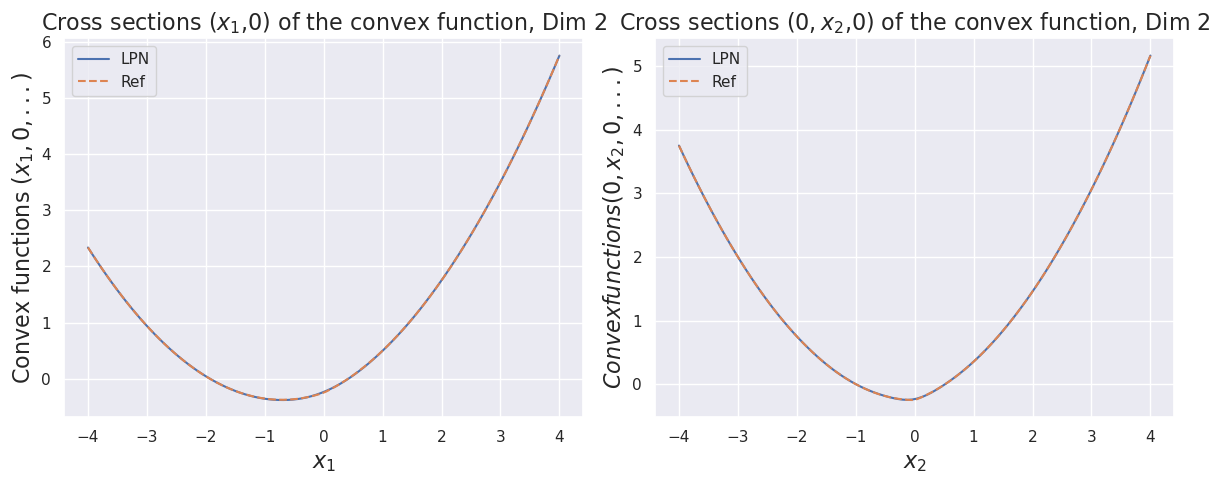

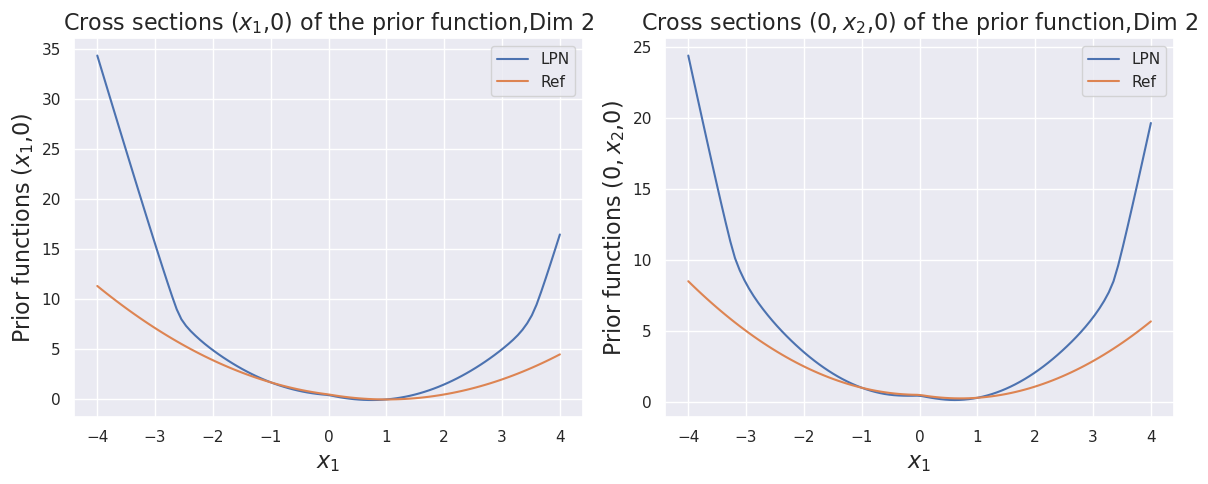

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 12.571150779724121
iteration 0 loss 396.7104797363281


iteration 5000 loss 0.00016364562907256186


iteration 10000 loss 6.906381895532832e-05


iteration 15000 loss 3.814502997556701e-05


iteration 20000 loss 3.569858017726801e-05


iteration 25000 loss 2.333056545467116e-05


iteration 30000 loss 3.3012642234098166e-05


iteration 35000 loss 3.724095586221665e-05


iteration 40000 loss 1.7885333363665268e-05


iteration 45000 loss 1.6052970750024542e-05


iteration 50000 loss 1.4577832189388573e-05


iteration 55000 loss 1.3121163647156209e-05


iteration 60000 loss 1.246168994839536e-05


iteration 65000 loss 1.2287317076697946e-05


iteration 70000 loss 0.004758548457175493


iteration 75000 loss 9.511140888207592e-06


iteration 80000 loss 9.89441014098702e-06


iteration 85000 loss 4.261950743966736e-05


iteration 90000 loss 7.662074494874105e-06


iteration 95000 loss 1.2709677321254276e-05


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 7.778291546856053e-06


iteration 105000 loss 5.843063718202757e-06


iteration 110000 loss 4.768420694745146e-06


iteration 115000 loss 4.164600341027835e-06


iteration 120000 loss 3.7680647437809967e-06


iteration 125000 loss 3.441803755777073e-06


iteration 130000 loss 3.1916670195641927e-06


iteration 135000 loss 2.9641068977070972e-06


iteration 140000 loss 2.794016609186656e-06


iteration 145000 loss 2.635247255966533e-06


iteration 150000 loss 2.4972430310299387e-06


iteration 155000 loss 2.3672203042224282e-06


iteration 160000 loss 2.2572198759007733e-06


iteration 165000 loss 2.1637458758050343e-06


iteration 170000 loss 2.0594566194631625e-06


iteration 175000 loss 1.983148649742361e-06


iteration 180000 loss 1.9119729586236645e-06


iteration 185000 loss 1.834870317907189e-06


iteration 190000 loss 1.7623908661335008e-06


iteration 195000 loss 1.7042219724316965e-06


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 1.651109300837561e-06


iteration 205000 loss 1.620232410459721e-06


iteration 210000 loss 1.5675717577323667e-06


iteration 215000 loss 1.51905874190561e-06


iteration 220000 loss 1.4739740663571865e-06


iteration 225000 loss 1.4296523431767127e-06


iteration 230000 loss 1.3884409781894647e-06


iteration 235000 loss 1.350607590211439e-06


iteration 240000 loss 1.3140428336555487e-06


iteration 245000 loss 1.28223427964258e-06


iteration 250000 loss 1.2483751561376266e-06


iteration 255000 loss 1.2183660373921157e-06


iteration 260000 loss 1.1899038554474828e-06


iteration 265000 loss 1.162161993306654e-06


iteration 270000 loss 1.1348977295710938e-06


iteration 275000 loss 1.1098146615040605e-06


iteration 280000 loss 1.085571284420439e-06


iteration 285000 loss 1.0623922435115674e-06


iteration 290000 loss 1.0404388604001724e-06


iteration 295000 loss 1.019034129967622e-06


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 9.98735572466103e-07


iteration 305000 loss 9.941941243596375e-07


iteration 310000 loss 9.750820026965812e-07


iteration 315000 loss 9.56542749008804e-07


iteration 320000 loss 9.383082328895398e-07


iteration 325000 loss 9.208301889884751e-07


iteration 330000 loss 9.044782700584619e-07


iteration 335000 loss 8.885482998266525e-07


iteration 340000 loss 8.734415928302042e-07


iteration 345000 loss 8.582660484535154e-07


iteration 350000 loss 8.440558758593397e-07


iteration 355000 loss 8.30017654607218e-07


iteration 360000 loss 8.264958637482778e-07


iteration 365000 loss 8.028477509469667e-07


iteration 370000 loss 7.903842060841271e-07


iteration 375000 loss 7.782805937495141e-07


iteration 380000 loss 7.667924819543259e-07


iteration 385000 loss 7.550303848802287e-07


iteration 390000 loss 7.435284601342573e-07


iteration 395000 loss 7.327107596211135e-07


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 7.225652893794177e-07


iteration 405000 loss 7.201645075838314e-07


iteration 410000 loss 7.107140049811278e-07


iteration 415000 loss 7.010615945546306e-07


iteration 420000 loss 6.917207997503283e-07


iteration 425000 loss 6.825914624641882e-07


iteration 430000 loss 6.737449780302995e-07


iteration 435000 loss 6.649896135968447e-07


iteration 440000 loss 6.56260738196579e-07


iteration 445000 loss 6.478988439084787e-07


iteration 450000 loss 6.396590492840915e-07


iteration 455000 loss 6.315559062386455e-07


iteration 460000 loss 6.236622311917017e-07


iteration 465000 loss 6.158558676361281e-07


iteration 470000 loss 6.082798336137785e-07


iteration 475000 loss 6.009000230733363e-07


iteration 480000 loss 5.936131515227316e-07


iteration 485000 loss 5.864883405592991e-07


iteration 490000 loss 5.794995558972005e-07


iteration 495000 loss 5.726616336687584e-07


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


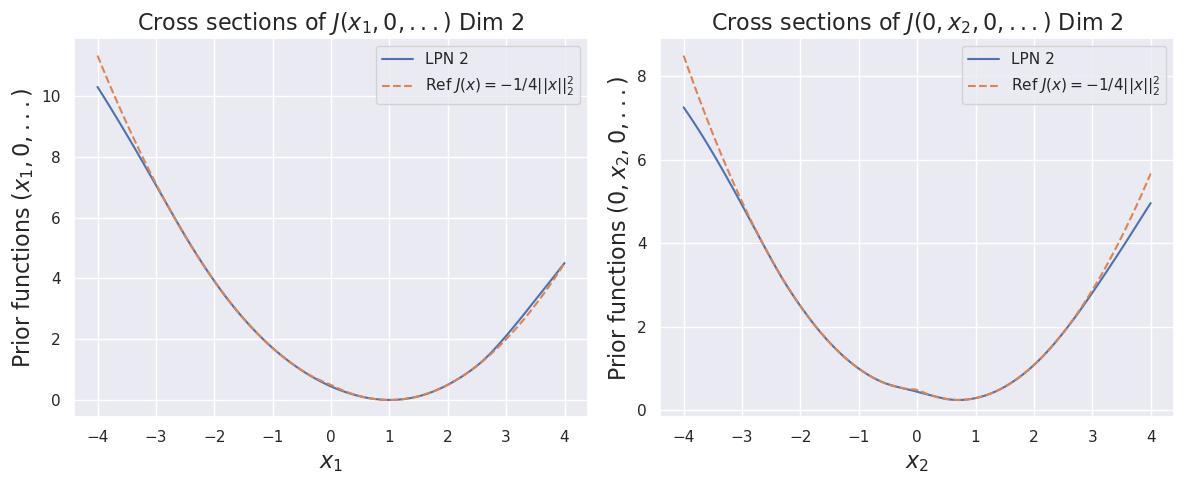

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)